# Dynamical rocking curve simulation 
In this study, we will show how to simulate and integrate a rocking curve using the blochwave approach.
We will see the effect of dynamical diffraction and compare it to the kinematical case.

## Preliminaries 
### import all packages

In [3]:
from utils import* #import display functionalities pandas,numpy,etc...
import utils    ;print('utils    :%s' %utils.__version__)
import EDutils  ;print('EDutils  :%s' %EDutils.__version__)
import blochwave;print('blochwave:%s' %blochwave.__version__)
from scattering import scattering_factors as sf # scattering_factors
from scattering import structure_factor as sF   # structure_factors
from blochwave import bloch_pp as bl            # bloch rocking curve 
from EDutils import utilities as ut             # utilities
from scipy.integrate import trapz               # for some manual integrations
from ed_patch import*                           # functions defined in this folder
%matplotlib inline
# dsp.matplotlib.use('agg')
cif_file='resources/LTA.cif'
figs = (18,5)

utils    :1.4
EDutils  :1.3dev
blochwave:1.3dev


### Importing the structure
We choose for this demo LTA which has chemical formula is $SiO_2$ and crystalllizes in space group [221](http://img.chem.ucl.ac.uk/sgp/LARGE/221az1.htm) $Pm\bar 3 m$.
1 | 2 | 3
-- | -- |--
![](figs/lta_a.png) | ![](figs/lta_1.png)  | ![](figs/lta_2.png) 

In [2]:
import crystals
crys = crystals.Crystal.from_cif(cif_file)
print('formula     : ',crys.chemical_formula)
print('lat_params  : ',crys.lattice_parameters)
print('space_group : ','\n  '.join( [''] + [ '%s : %s' %(k.ljust(20),str(v)) for k,v in crys.symmetry().items() ]))
print('nb atoms    : ', len(crys.atoms)) 

crys.rho = len(crys.atoms)/(crys.volume) #/A^3
print('density : %d atoms/nm^3'  %(crys.rho*1e3) )

atoms = np.array([np.hstack([a.coords_fractional,int(a.atomic_number)]) for a in crys.atoms])
n_silicon=len(atoms[atoms[:,-1]==14])
n_oxygen=len(atoms[atoms[:,-1]==8])
print('n_silicon :',n_silicon)
print('n_oxygen  :',n_oxygen)
rho_g = (n_silicon*28.085 + n_oxygen*16 )/cst.Na/(crys.volume*1e-24)
print('density : %.2f g/cm^3'  %rho_g )

formula     :  O2 Si
lat_params  :  (11.9, 11.9, 11.9, 90.0, 90.0, 90.0)
space_group :  
  international_symbol : Pm-3m
  hall_symbol          : -P 4 2 3
  hm_symbol            : Pm-3m
  centering            : CenteringType.primitive
  international_number : 221
  hall_number          : 517
  international_full   : P 4/m -3 2/m
  pointgroup           : m-3m
nb atoms    :  72
density : 42 atoms/nm^3
n_silicon : 24
n_oxygen  : 48
density : 1.42 g/cm^3


### Scattering form factors

For a scattering problem with an incident wave $e^{2i\pi k_0z}$, far field wave function can usually be approximated as : 
\begin{equation}
    \Psi(\mathbf r) = e^{2i\pi k_0z} + \frac{e^{2i\pi kr}}{r}f(\theta)
\end{equation}

where $k_0=1/\lambda$ is the wave number.

The scatttering factors are originally determined from the [Born approximation](#https://en.wikipedia.org/wiki/Born_approximation) (see [Kirkland2019](#Kirkland2019) ): 

\begin{equation}
    f_e(q) = \frac{2\pi m_0e}{h^2}\int V_a(\mathbf r)e^{2i\pi\mathbf q\cdot\mathbf r}d^3r
\end{equation}

where $f_e$(measured in Angstrom) is the scattering factor, $m_0$ the electron rest mass, $e$ the elementary charge, $h$ is Plank's constant, $V_a$ is the atomic potential for each element and $\mathbf q$ is the transfer vector momentum.

#### Mott-Bethe formula 
Since the potential of the atom is expressed from the atomic number $Z$ and the electronic density $f_x(\mathbf r,Z)$ the electronic form factors can be obtained from the X-ray form factor through the [Mott-Bethe formula](#https://en.wikipedia.org/wiki/Mott%E2%80%93Bethe_formula) :  

\begin{equation}
    f_e(q,Z) = \frac{2m_0e^2}{h^2}\left(\frac{Z-f_x(q)}{q^2}\right)
\end{equation}

where $q=2\sin(\theta/2)/\lambda$ where $\theta$ is the scattering angle.
Note that the convention for $q$ represents the actual distances in reciprocal space(see struture factor below).

The form factors have been parametrized and tabulated for all atoms.

#### Kirkland parametrization
Earl J. Kirkland uses a fit with 3 Lorentzian and 3 Gaussians : 
\begin{equation}
    f(q) = \sum_{i=1}^{3} \frac{a_i}{q^2+b_i} + c_i\exp\left(-d_iq^2\right)
\end{equation}


#### Popular Gaussian parametrization 
[Shelxl](https://srv.mbi.ucla.edu/faes/) uses a fit with 4 gaussians : 
\begin{equation}
    f(s) = \sum_{j=1}^{4} a_j\exp\left(-b_js^2\right)
\end{equation}
where $s=\sin(\theta_B)/\lambda=q/2$ is the scattering parameter and $\theta_B$ is the Bragg scattering angle. 


#### Comparing parametrization 
The fits are compared below. Note that at large values the fits seem to differ a little bit, especially at $q>4^{-1}$  for silicon.

In [3]:
#### Comparing atom factors
## choosing the atomic elements
df_Z = pd.DataFrame([['C',6,'k'],['O',8,'r'],['Si',14,'b'],['Au',79,'y']],columns=['elt','Z','c'])
print(df_Z[['elt','Z','c']])

## getting the form factors
q=np.linspace(0,10,1000)
fe_EJK = sf.get_fe(df_Z.Z  ,q=q,fit='kirkland')
fe_SLX = sf.get_fe(df_Z.elt,q=q,fit='shelxl')

  elt   Z  c
0   C   6  k
1   O   8  r
2  Si  14  b
3  Au  79  y


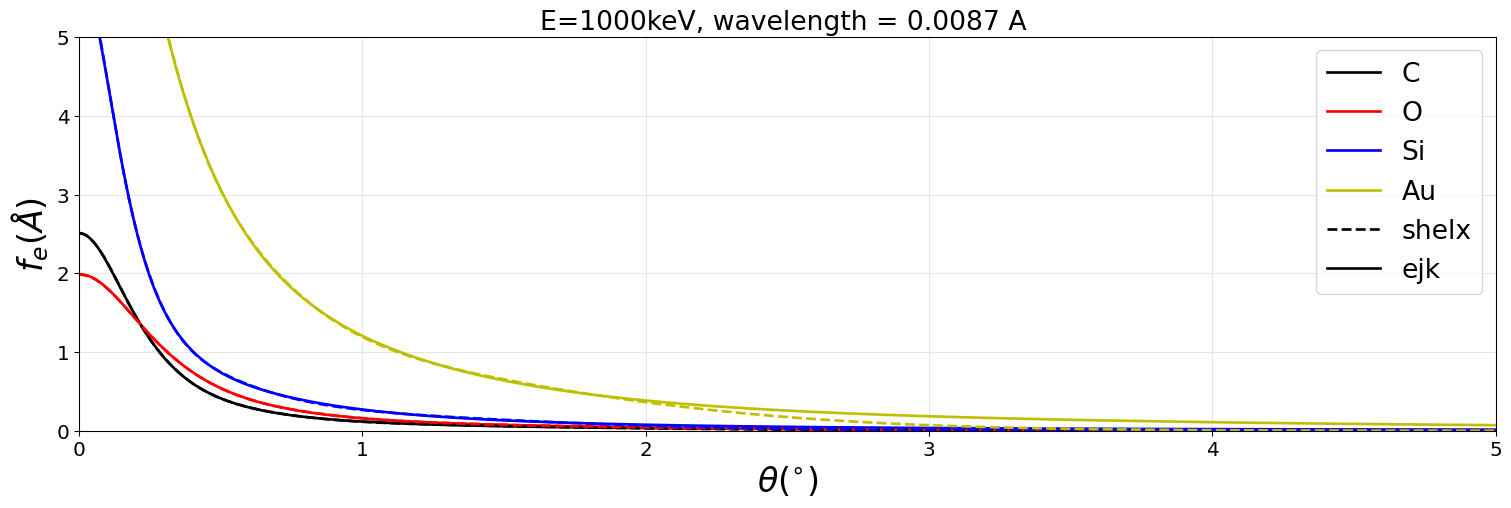

In [21]:
# x = 'q'
x = 'theta'

keV=1000
lam=cst.keV2lam(keV)
theta=2*np.arcsin(q*lam/2)

xx   = {'q':q,'theta':np.rad2deg(theta)}
labx = {'q':r'$q(\AA^{-1})$','theta':r'$\theta(^{\circ})$'}
title= {'q':'universal curves','theta':'E=%dkeV, wavelength = %.4f A ' %(keV,lam)}
## displaying
plts =[[xx[x],fe_EJK[:,i],[r.c,'-' ],''] for i,r in df_Z.iterrows()]
plts+=[[xx[x],fe_SLX[:,i],[r.c,'--'],''] for i,r in df_Z.iterrows()]
legElt = {elt:c for elt,c in df_Z[['elt','c']].values};legElt.update({'shelx':'k--','ejk':'k-'})
dsp.stddisp(plts,figsize=figs,legElt=legElt,opt='',lw=2,
    labs=[labx[x],'$f_e(\AA)$'],title=title[x],
    xylims=[0,5,0,5],
    );

### cross section
The differential cross section is simply deduced as the square of the form factor. Its integration yields the total cross section (in $A^2$) : 
\begin{eqnarray}
    \sigma 
        &=& \int |f(\theta)|^2 d\Omega \\
        &=& 2\pi\int_0^{\pi}|f(\theta)|^2\sin(\theta)d\theta
\end{eqnarray}

In [22]:
sig_Z = fe_EJK**2

df_Z['sig_tot(A^2)'] = [2*np.pi*trapz(sig*np.sin(theta),theta) for sig in sig_Z.T ]
print(df_Z[['elt','sig_tot(A^2)']].to_string())

  elt  sig_tot(A^2)
0   C      0.000314
1   O      0.000354
2  Si      0.001155
3  Au      0.011332


As seen below the cross sections at 1000keV for the most common atoms found in organic compounds are on the order of $\sigma=0.0003A^2$.

An average mean mean free path $l$ (Angstrom) can be computed with : 

\begin{eqnarray}
    l = \frac{1}{\sigma_{avg}\rho} 
\end{eqnarray}

where $\rho$ is the density of the material.

In [23]:
l = 1/(df_Z['sig_tot(A^2)'].mean()*crys.rho) #A
print('l = %d nm ' %(l/10))

l = 711 nm 


### Structure factors 
The [structure factor](https://en.wikipedia.org/wiki/Structure_factor) exact formula is : 
\begin{equation}
    F(q) = \sum_j f_j^{(e)}(q)\exp(-2i\pi \mathbf q\cdot\mathbf r_j)
\end{equation}
where : 

- $j$ runs over the atoms in the unit cell, 

- $\mathbf{r_j} = x_j \mathbf a + y_j\mathbf b + z_j\mathbf c$ are the atomic coordinates. $(x_j,y_j,z_j)$ are known as the fractional coordinates and $(\mathbf a,\mathbf b,\mathbf c)$  is the real crystal basis.

- $\mathbf{q} = h \mathbf a^{\ast} + k\mathbf b^{\ast} + h\mathbf c^{\ast}$ is the scattering vector in reciprocal space of reflection $(h,k,l)$ where $(\mathbf a^{\ast},\mathbf b^{\ast},\mathbf c^{\ast})$ is the reciprocal lattice of the crystal in crystallographic convention $\mathbf a_i\cdot a_j^{\ast}=\delta_{ij}$.
<!-- - (i.e. $\mathbf a^{\ast}=\frac{\mathbf b \times \mathbf c}{V_{cell}}$ ). -->

Note that : 

- In virtue of the above real and reciprocal lattice relations we have $\mathbf q\cdot\mathbf r_j=hx_j+ky_j+lz_j$.
- The unit of the structure factor is the same as the scattering factor i.e. $A$.


In [24]:
df_Fhkl = sF.get_structure_factor(cif_file,hklMax=10)
df_Fhkl['Fga']  = np.real(np.abs(df_Fhkl.F))
df_Fhkl['Vg']   = df_Fhkl.Fga/crys.volume
h = [str((i,i,0)) for i in range(1,10)]
print(df_Fhkl.loc[h,['q','Fga','Vg']].to_string())

                  q        Fga        Vg
(1, 1, 0)  0.118841  38.497979  0.022845
(2, 2, 0)  0.237683  36.910746  0.021903
(3, 3, 0)  0.356524  23.444312  0.013912
(4, 4, 0)  0.475366  22.465977  0.013332
(5, 5, 0)  0.594207  26.888793  0.015956
(6, 6, 0)  0.713049   8.410315  0.004991
(7, 7, 0)  0.831890   3.328647  0.001975
(8, 8, 0)  0.950732   3.722291  0.002209
(9, 9, 0)  1.069573   3.027950  0.001797


## Theory
### kinematic approximation
The intensity of a Bragg spot in the kinematic regime can be established [[CowleyMoodie1957](#CowleyMoodie1957),[SubramanianSpence2015](#SubramanianSpence2015)] as :
\begin{equation}
  I_{kin} = \left(\sigma v_g t\right)^2 \left(\sin\left(\pi S_gt\right)/\left(\pi S_gt \right)\right)^2        
\end{equation}

where : 

- $\sigma=2\pi m_0e\lambda/h^2$ the interaction parameter (in $rad/kVA$).
- $v_g$ the Fourier components (in $V$).
- $t$ is the thickness.
- $S_g$ is the excitation error, i.e. the distance of the reflection to the Ewald sphere.

Note that the shape and width of the rocking curve in the kinematic regime do not depend on the energy of the source but only the thickness of the sample and the excitation error. In practice beams may stay in diffracting condition for quite some time at large energies as the Ewald sphere is extremely flat. The energy of the source in the kinematic approximation only affects the amplitude of the rocking curve through the interaction parameter.

E=1000keV, sigma=0.54A, Vg=2.28e-02


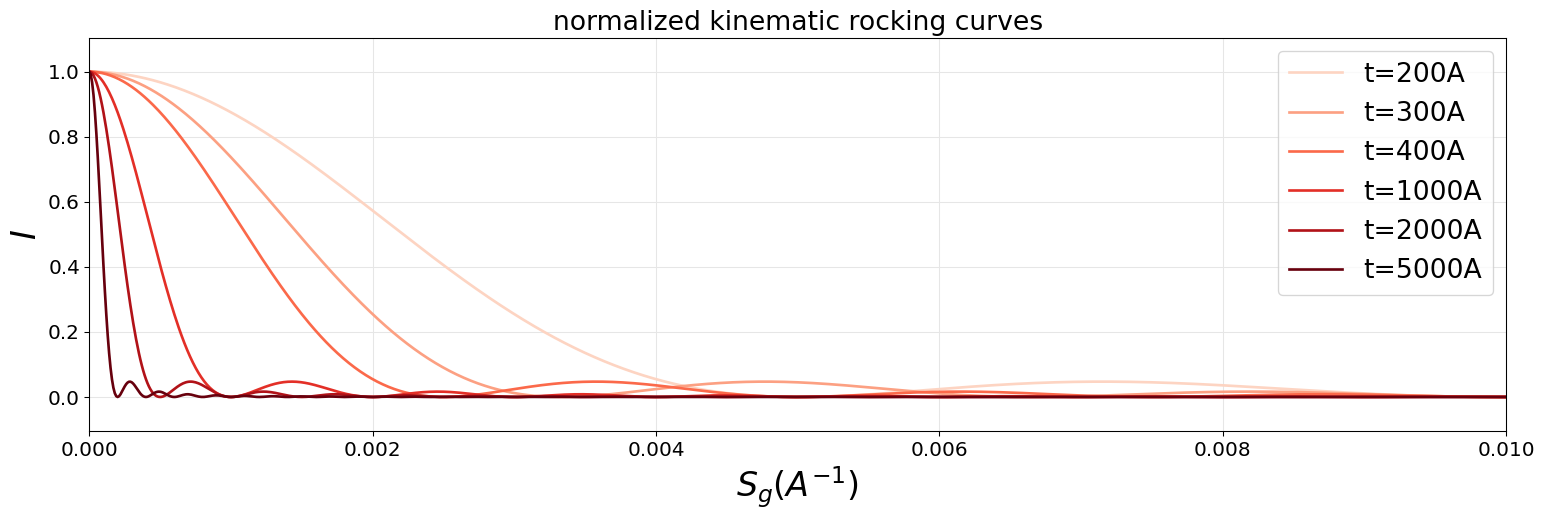

In [25]:
h = (0,1,1)
keV=1000
sig=cst.keV2sigma(keV)
Vg=df_Fhkl.loc[str(h),'Vg']
print('E=%dkeV, sigma=%.2fA, Vg=%.2e'%(keV,sig,Vg))
Ikin = lambda sg,t,sig_Vg : ((sig_Vg*t)*np.sinc(sg*t))**2

sg = np.linspace(0,0.01 ,1000)
thicks = [200,300,400,1000,2000,5000]
I_kins = [ Ikin(sg,t,sig*Vg) for t in thicks]
plts = [[sg,I/I.max(),[c,'-'],'t=%dA' %t] for I,t,c in zip(I_kins,thicks,dsp.getCs('Reds',len(thicks)))] 
dsp.stddisp(plts,lw=2,title='normalized kinematic rocking curves',
        figsize=figs,labs=['$S_g(A^{-1})$','$I$'],
        xylims=['x',0,0.01],opt='');

### Pendulosung thickness

We can also write $I_{kin}$ terms of pendullosung thickness 


\begin{equation}
    I_{kin} = \left(\frac{\pi t}{\xi_g}\right)^2 \textrm{sinc}^2\left(S_gt\right)
\end{equation}
where 

- $ \xi_g=k_0/U_g$ is known as the pendullosung thicknesss.
- $U_g=2m_0e/h^2v_g=\sigma v_g k_0 /\pi$ are the Blochwave structure factors entries.


Note that $U_g$ is in practice computed from the structure factors through : 

\begin{equation}
  U_g=\frac{F_g \gamma}{\pi\mathcal V_{cell}}
\end{equation}


Note the inclusion of $\gamma$ for relativistic effect. At 1MeV this factor is as high as 3 which is a significant relativisitc correction.

In [31]:
keV=1000
lam=cst.keV2lam(keV)
k0=1/lam
meff=cst.meff(keV)
print('E=%dkeV, wavelength=%.3fA, k0=%.1fA-1, meff=%.2f'%(keV,lam,k0,meff))

df_Fhkl['Ug']   = df_Fhkl.Fga*meff/(np.pi*crys.volume)
df_Fhkl['xi_g'] = k0/df_Fhkl.Ug
h = [str((i,i,0)) for i in range(1,10)]
print(df_Fhkl.loc[h,['q','Fga','Vg','Ug','xi_g']].to_string())

E=1000keV, wavelength=0.009A, k0=114.7A-1, meff=2.96
                  q        Fga        Vg        Ug          xi_g
(1, 1, 0)  0.118841  38.497979  0.022845  0.021503   5333.751338
(2, 2, 0)  0.237683  36.910746  0.021903  0.020616   5563.112937
(3, 3, 0)  0.356524  23.444312  0.013912  0.013095   8758.570093
(4, 4, 0)  0.475366  22.465977  0.013332  0.012548   9139.983048
(5, 5, 0)  0.594207  26.888793  0.015956  0.015018   7636.588435
(6, 6, 0)  0.713049   8.410315  0.004991  0.004697  24415.096790
(7, 7, 0)  0.831890   3.328647  0.001975  0.001859  61688.315826
(8, 8, 0)  0.950732   3.722291  0.002209  0.002079  55164.581342
(9, 9, 0)  1.069573   3.027950  0.001797  0.001691  67814.416920


### 2 beam theory 

For a $2\times 2$ blochwave matrix, the solution can be obtained [analytically](#Zuo1992) to yield the following theoretical 2 beam intensity for the diffracted beam : 
\begin{equation}
  I_{dyn-2} = \frac{\sin^2\left(\pi t/\xi_g\sqrt{1+w_g^2}\right)}{1+w_g^2}
\end{equation}

where $w_g=\xi_gS_g$.

Note that the primary beam is then $I_0=1-I_{dyn-2}$.

For small values of the thickness $t\ll \xi_g$ and $w_g\gg 1$, the expression reduces to the kinematic case $\left(\frac{\pi t}{\xi_g}\right)^2 \textrm{sinc}^2\left(S_gt\right)$.

### comparison of rocking curves
Let's compare the kinematic and 2-beam dynamical rocking curves for some sampled reflections.

xi_g=5333 A


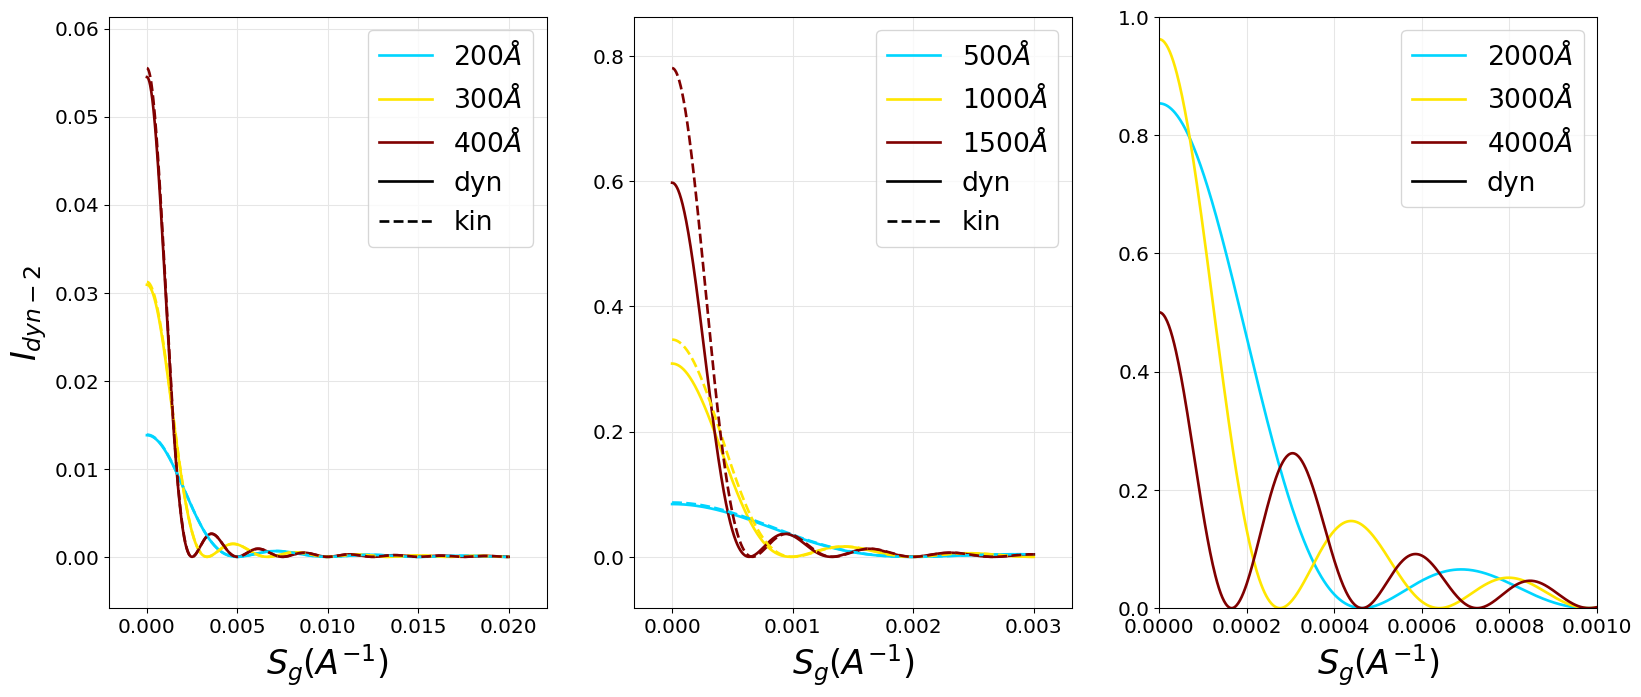

In [29]:
df=df_Fhkl
h = (0,1,1)
xi_g = np.real(df.loc[str(h)].xi_g); print('xi_g=%d A' %xi_g)

Ikin = lambda sg,t,xi_g : ((np.pi*t/xi_g)*np.sinc(sg*t))**2
Idyn = lambda wg,t,xi_g : np.abs(np.sin(np.pi * t/xi_g*np.sqrt(1+wg**2))/np.sqrt(1+wg**2))**2


def plot_I2(sg,thicks,dyn=True,kin=True,cmap='jet',**kwargs):
    wg=sg*xi_g
    plts,legElt = [],{'$%d\AA$' %t:[c,'-'] for t,c in zip(thicks,dsp.getCs(cmap,len(thicks)))}
    if dyn:
        I_dyns = [ Idyn(wg,t,xi_g) for t in thicks]
        plts = [[sg,I,c,''] for I,t,c in zip(I_dyns,thicks,dsp.getCs(cmap,len(thicks)))] 
        legElt['dyn']='k-'    
    if kin:
        I_kins = [ Ikin(sg,t,xi_g) for t in thicks]
        plts+= [[sg,I,[c,'--'],''] for I,t,c in zip(I_kins,thicks,dsp.getCs(cmap,len(thicks)))] 
        legElt['kin']='k--'
        
    return dsp.stddisp(plts,lw=2,legElt=legElt,**kwargs);
args=dict(opt='',setPos=False)    
fig,(ax1,ax2,ax3) = dsp.create_fig(rc=(1,3),figsize=(20,8))
plot_I2(sg = np.linspace(0,0.02 ,1000),thicks = [200,300,400]      ,kin=True ,ax=ax1,labs=['$S_g(A^{-1})$','$I_{dyn-2}$'],**args);
plot_I2(sg = np.linspace(0,0.003,1000),thicks = [500,1000,1500]    ,kin=True ,ax=ax2,labs=['$S_g(A^{-1})$',''],**args);
plot_I2(sg = np.linspace(0,0.002,1000),thicks = [2000,3000,4000]   ,kin=False ,ax=ax3,labs=['$S_g(A^{-1})$',''],xylims=[0,0.001,0,1],**args);

### Integrating the rocking curve

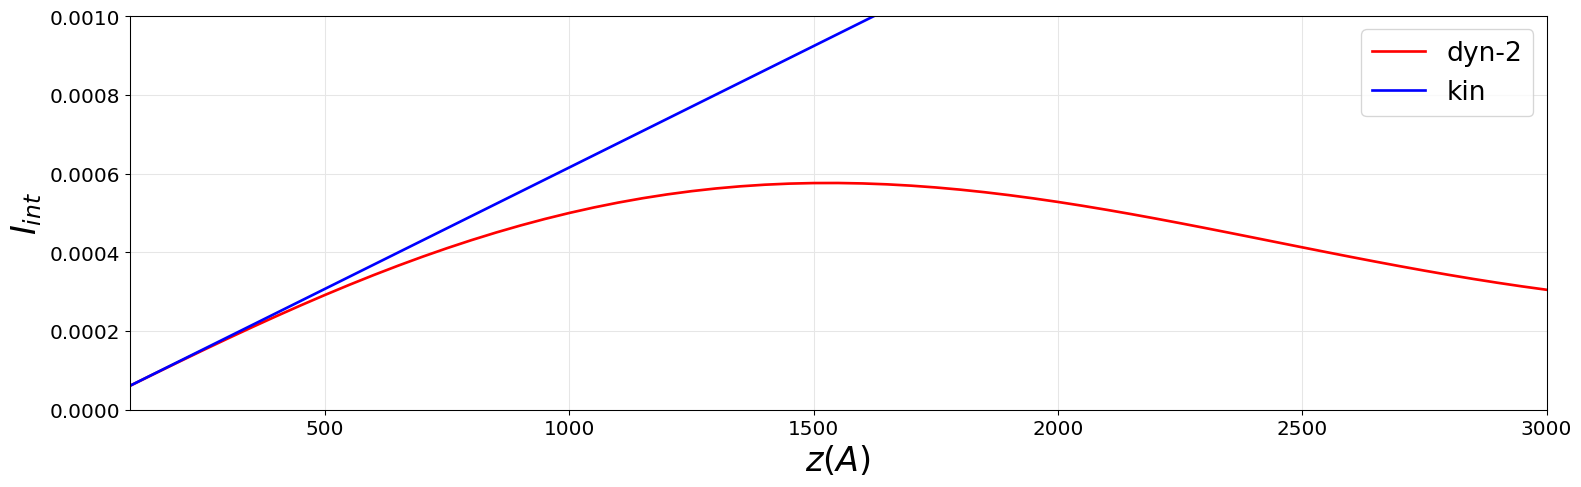

In [32]:
thicks=np.arange(100,3001,50)
npts = 10000
xi_g = 4000
sg = np.linspace(0,0.05,npts)

Idyn2 = 2*np.array([trapz(Idyn(sg*xi_g,t,xi_g),sg) for t in thicks])
Ikins = 2*np.array([trapz(Ikin(sg     ,t,xi_g),sg) for t in thicks])

plts =[[thicks,Idyn2,'r-','dyn-2']]
plts+=[[thicks,Ikins,'b-','kin']]
dsp.stddisp(plts,labs=['$z(A)$','$I_{int}$'],lw=2,figsize=figs,opt='',
           xylims=[100,3000,0,0.001],
           );

## Bloch wave simulation

### Single Blochwave simulation 

In [33]:
u  = np.array([0.66865363, 0.29164837, 0.6521759 ])
u  = u/np.linalg.norm(u)
b=blochwave.bloch.Bloch(path='dat/LTA',cif_file=cif_file,Smax=0.005,keV=1000,Nmax=8,solve=True,)

 ...assembling 289x289 matrix (structure factor shape : (33, 33, 33)) ...             
...diagonalization...
object saved
dat/LTA/LTA001_1000keV_bloch.pkl
object saved
dat/LTA/LTA001_1000keV_bloch.pkl


The relections info are stored in a dataframe `df_G`. The function `show_df_G` nicely formats the output.

In [34]:
b.show_df_G(n=10)

                  Sw         Fg      Fg2       Vg      Uga  xi_g
(0, 0, 0)    0.0e+00   0.0+0.0j      0.0 0.00e+00  0.0e+00   inf
(0, 1, 0)   -3.1e-05 -52.4-0.0j   2747.0 3.11e-02  2.9e-02  3918
(1, 0, 0)   -3.1e-05 -52.4-0.0j   2747.0 3.11e-02  2.9e-02  3918
(-1, 0, 0)  -3.1e-05 -52.4+0.0j   2747.0 3.11e-02  2.9e-02  3918
(0, -1, 0)  -3.1e-05 -52.4+0.0j   2747.0 3.11e-02  2.9e-02  3918
(1, 1, 0)   -6.2e-05 -38.5-0.0j   1482.1 2.28e-02  2.2e-02  5334
(-1, 1, 0)  -6.2e-05 -38.5+0.0j   1482.1 2.28e-02  2.2e-02  5334
(1, -1, 0)  -6.2e-05 -38.5-0.0j   1482.1 2.28e-02  2.2e-02  5334
(-1, -1, 0) -6.2e-05 -38.5+0.0j   1482.1 2.28e-02  2.2e-02  5334
(0, 2, 0)   -1.2e-04  12.4+0.0j    154.2 7.37e-03  6.9e-03 16534


### Solving a 2x2 system
We can artificially force solving a 2x2 system by specifying the reflections that we want in the simulation.

In [35]:
hkl = np.array([[0,0,0],[0,-1,0]])
b.solve(hkl=hkl,thick=500,opts='svt')
b._set_beams_vs_thickness(thicks=(0,6000,1000))
b.show_df_G(n=2)

 ...assembling 2x2 matrix (structure factor shape : (33, 33, 33)) ...             
...diagonalization...
updated intensities
object saved
dat/LTA/LTA001_1000keV_bloch.pkl
... beam vs thickness ...
                 Sw         Fg      Fg2       Vg      Uga  xi_g
(0, 0, 0)   0.0e+00   0.0+0.0j      0.0 0.00e+00  0.0e+00   inf
(0, -1, 0) -3.1e-05 -52.4+0.0j   2747.0 3.11e-02  2.9e-02  3918


xi_g=3917A, apparent xi_g=3888A


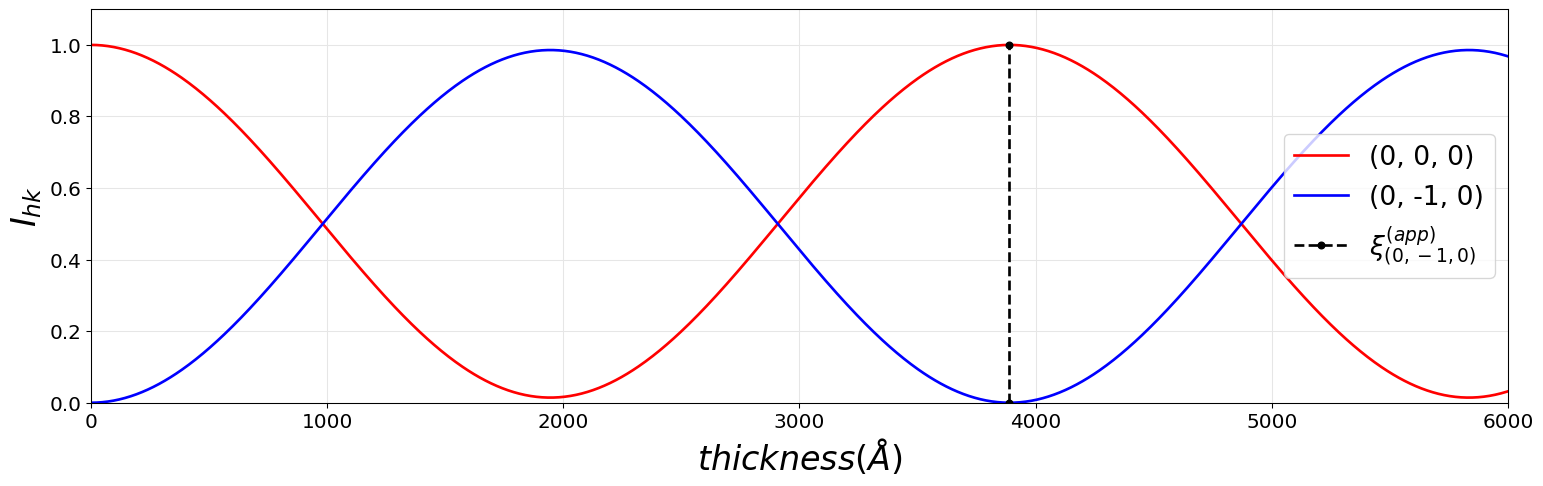

In [36]:
h0 = str(tuple(hkl[1]))
xi_g0,sw = np.real(b.df_G.loc[h0,['xi_g','Sw']].values)
wg = sw*xi_g
xi_g=xi_g0/np.sqrt(1+wg**2)
print('xi_g=%dA, apparent xi_g=%dA' %(xi_g0,xi_g))

plts = [[b.z,I,c,h] for h,I,c in zip (b.df_G.index,b.Iz,['r','b']) ]
plts+= [[[xi_g]*2,[0,1],'k--o',r'$\xi_{%s}^{(app)}$' %h0]]
dsp.stddisp(plts,labs=['$thickness(\AA)$','$I_{hk}$'],lw=2,figsize=figs,opt='',
            xylims=[0,6000,0,1.1],
           );

## Rocking curve 
### Orientation Setup
We chose a random orientation $\mathbf u$ and the rotation axis to be $\mathbf e_{rot}=\mathbf e_z\times\mathbf u$.
An oscillation range and a number of points are specified to simulate a rocking curve around the $\mathbf e_{rot}$ axis about $\mathbf u$.

In [37]:
u   = np.array([0.66865363, 0.29164837, 0.6521759 ])
u   = u/np.linalg.norm(u)
uvw = ut.get_uvw(u,osc=80,npts=40)

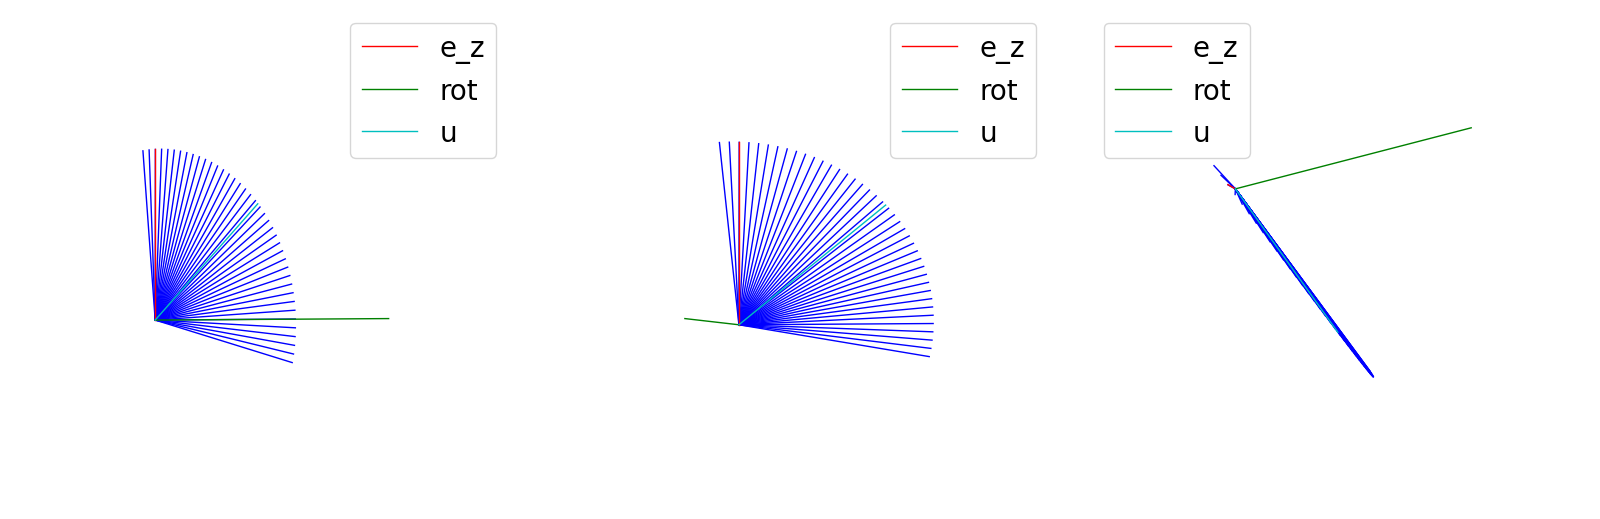

In [38]:
### gather plots
ez  = [0,0,1]
rot = np.cross(ez,u)
eij={'e_z':[ez,'r'],'rot':[rot,'g'],'u':[u,'c']}
plts = [[[0,u[0]],[0,u[1]],[0,u[2]],'b','',1] for u in uvw ]
plts+= [[[0,ei[0]],[0,ei[1]],[0,ei[2]] , c,k,5] for k,(ei,c) in eij.items()]

#Display orientations in differnt views
fig = plt.figure(figsize=figs)
views=[[0,0],[0,-90],[90,0]]
for i,view in enumerate(views):
    ax=plt.subplot(1,3,i+1,projection='3d')
    dsp.stddisp(plts,ax=ax,axPos=[i*0.3,0,0.3,1],legOpt=1,ticksOn=0,setPos=1,opt='')
    ax.view_init(elev=view[0] , azim=view[1]);


### Creating the rocking curve object

In [40]:
uvw=ut.get_uvw(u,osc=1,npts=100)
Sargs=dict(cif_file=cif_file,Smax=0.005,keV=1000,Nmax=12,solve=False,opt='',v=0)
name = 'test'
rock = bl.Bloch_cont(path='dat/LTA/rocks/%s' %name,uvw=uvw,tag='',Sargs=Sargs,
                     params=[],vals=[],
                     frames=np.arange(len(uvw)) )

...building index...
object saved
dat/LTA/rocks/test/rock_.pkl


### Excitation error profiles
We can plot the excitation errors as colormap for a series of beam as the crystal is rotated. In this way we can visualize which beam get into diffracting condition during the experiment and for how many frames they contribute to the diffraction pattern. 

77 beam within sw_min=5.00e-05


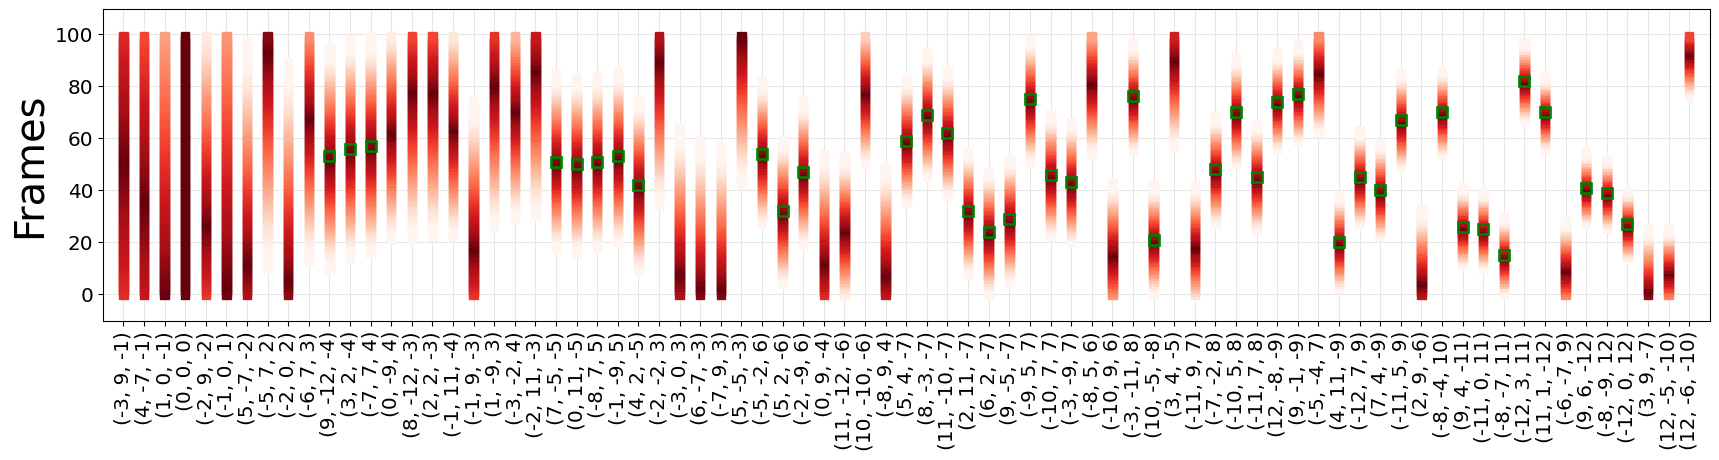

In [41]:
rock=ut.load_pkl('dat/LTA/rocks/test/rock_.pkl')
fig,ax=rock.show_excitation_map(vm=0.0045,sw_min=5e-5,nb_max=100,figs=figs,opt='');

We can also plot the excitation error profile for a selection of beams. 
We can see that the excitation errors evolve linearly as the rotation is performed. This is due to the flatteness of the Ewald sphere.
We can also note that all reflection do not go through the Ewald sphere at the same rate. This is due to the different distances of the reflections to the rotation axis. 

In [ ]:
swm=0.0045
hkls=rock.get_full_refl(Swm=swm)[:5]
cs = dsp.getCs('jet',len(hkls))
plts = [[r.Frame,np.abs(r.Sw),[c,'-o'],h] for c,(h,r) in zip(cs,rock.beams.loc[hkls].iterrows())]
plts+= [[[0,len(rock.df)],2*[swm],'k--','']]
dsp.stddisp(plts,figsize=figs,legOpt=1,opt='',
            labs=['Frame','$S_g$'],
            # xylims=['y',0,0.015],
    );

In [43]:
rock.do('solve',verbose=0,Smax=0.005,Nmax=8,opts='st',thick=500)
rock.do('_set_beams_vs_thickness', verbose=False,thicks=np.arange(10,5001,10),v=0)
print(rock.df[['nbeams']])

...Structure factors...
structure factors updated.
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated intensities
updated i

### Displaying rocking curves
We can compare the effect of dynamical diffraction to the case predicted by pure kinematic theory. We can see that dynamic corrections may be required for strong reflections on structures like LTA (unit cell characterstic lattice parameter 100A) for sample thickness as low as 500A.

total number of beams:1
Saving figure :
figs/rock_-5_0_5.png


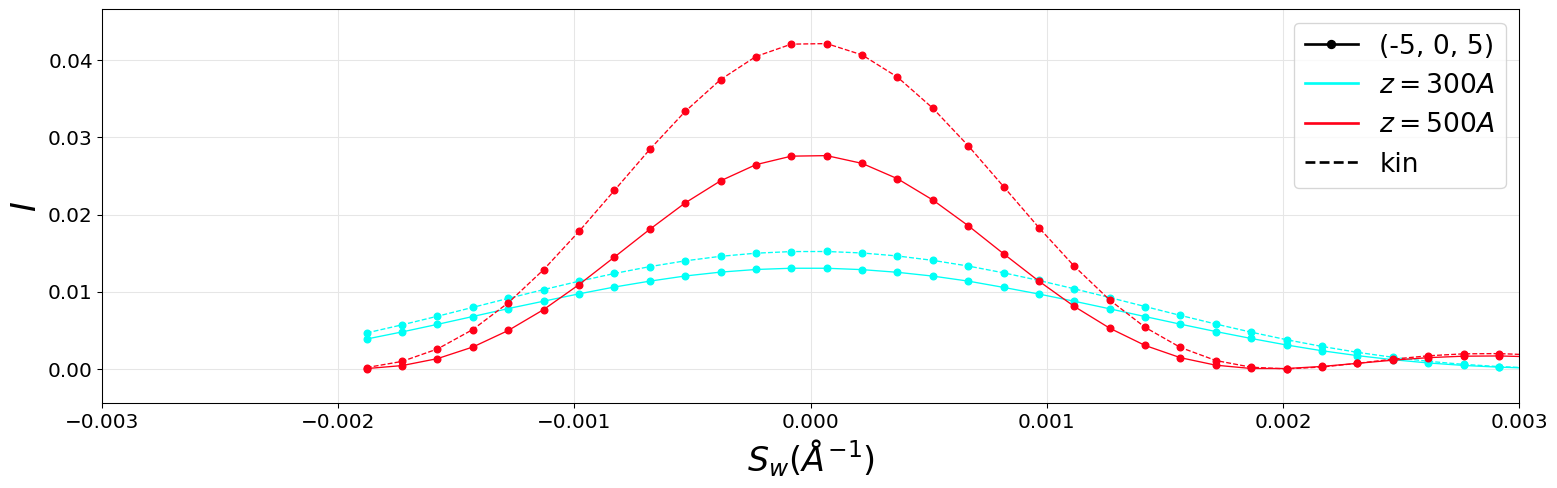

In [64]:
rock.plot_rocking(refl=[str((-5,0,5))],zs=[300,500],cmap='hsv',kin=True,figsize=figs,
                  xylims=['x',-0.003,0.003],
                  x='Sw',opt='s',name="figs/rock_-5_0_5.png");

total number of beams:4


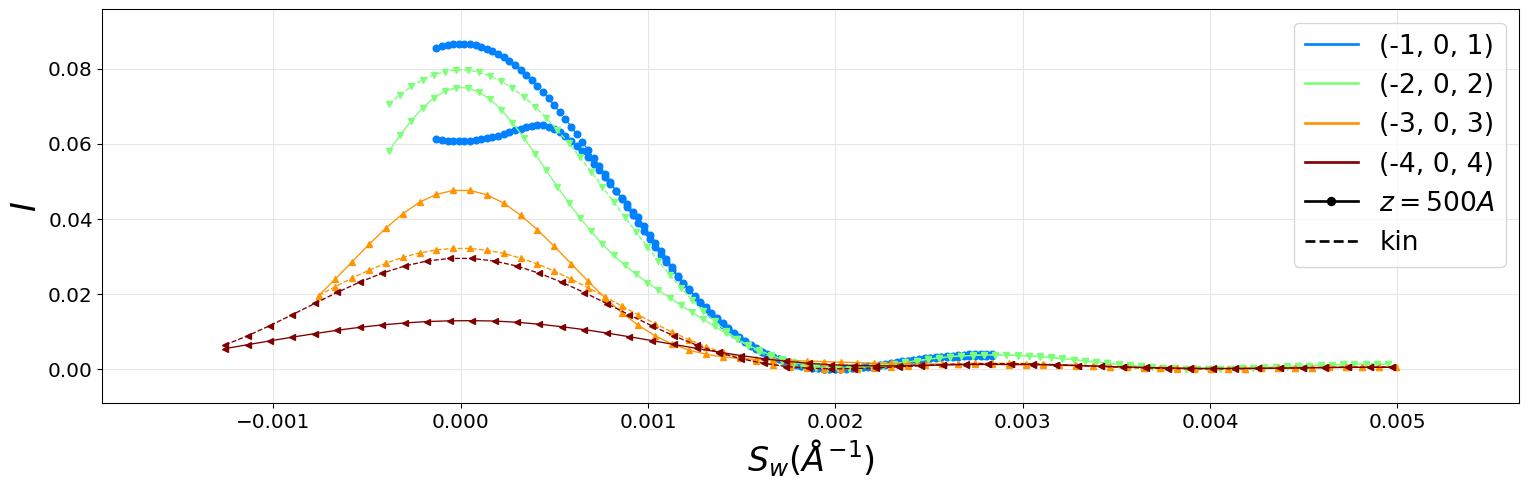

In [45]:
h=[str((-i,0,i)) for i in range(1,5)]
rock.plot_rocking(refl=[h],zs=[500],cmap='jet',kin=True,figsize=figs,
                  # xylims=['x',-0.002,0.002],
                  x='Sw',opt='');


we can plot the rocking curves for all the beams that complete their rocking curves.

In [46]:
rock=ut.load_pkl('dat/LTA/rocks/%s/rock_.pkl' %name)
hklf=rock.get_full_refl(Swm=swm)
z, Iz = rock.get_rocking(zs=[500],refl=hklf) 
### Iz is a dictionary giving the intensities at each frame and thicknesses for each beam 
### {h : I(frame,thick)}
Imax = {h:I[:,0].max() for h,I in Iz.items()}
rock.beams['Imax']=0
rock.beams.loc[list(Imax.keys()),'Imax']=list(Imax.values())
print(rock.beams.sort_values('Imax',ascending=0)[['nframes','f_range','Imax']])

total number of beams:76
              nframes       f_range      Imax
(5, 4, -7)         49  (35, 59, 83)  0.011819
(7, -5, -5)        68  (18, 51, 85)  0.006081
(-7, 7, 4)         84  (16, 57, 99)  0.002233
(-6, -2, 7)        48  (27, 50, 74)  0.001669
(8, -5, -6)        56  (11, 38, 66)  0.001465
...               ...           ...       ...
(-7, -9, 11)       30  (24, 39, 53)  0.000000
(-7, 0, 7)         41   (0, 17, 40)  0.000000
(-7, 2, 6)          5     (0, 0, 4)  0.000000
(-7, 3, 6)          9  (91, 99, 99)  0.000000
(9, 6, -12)        29  (27, 41, 55)  0.000000

[262 rows x 3 columns]


In [ ]:
name='test'
hklf = rock.beams.loc[rock.beams.Imax>1e-3].sort_values('Imax',ascending=False).index[:20]
zs = [100,200,500]
rep = lambda s:s.replace(', ','_').replace('(','').replace(')','') # used to 
for h in hklf:
    fig,ax=rock.plot_rocking(refl=[h],zs=zs,figsize=figs,name='figs/rock_%s_%s.png' %(name,rep(h)),opt='sc');

total number of beams:1
Saving figure :
figs/rock_test_5_4_-7.png
total number of beams:1
Saving figure :
figs/rock_test_7_-5_-5.png
total number of beams:1
Saving figure :
figs/rock_test_-7_7_4.png
total number of beams:1


In [49]:
from utils import jupy_utils
jupy_utils.show_hkls('figs','rock_test',hklf,n=5)


5_4_-7 | 7_-5_-5 | -7_7_4 | -6_-2_7 | 8_-5_-6
 -- |  -- |  -- |  -- |  --
![](figs/rock_test_5_4_-7.png) | ![](figs/rock_test_7_-5_-5.png) | ![](figs/rock_test_-7_7_4.png) | ![](figs/rock_test_-6_-2_7.png) | ![](figs/rock_test_8_-5_-6.png)


### Integrating rocking curves

In [50]:
rock._integrate_rocking(rock.beams.index,new=1)

object saved
dat/LTA/rocks/test/rock_.pkl
rock.Iz updated


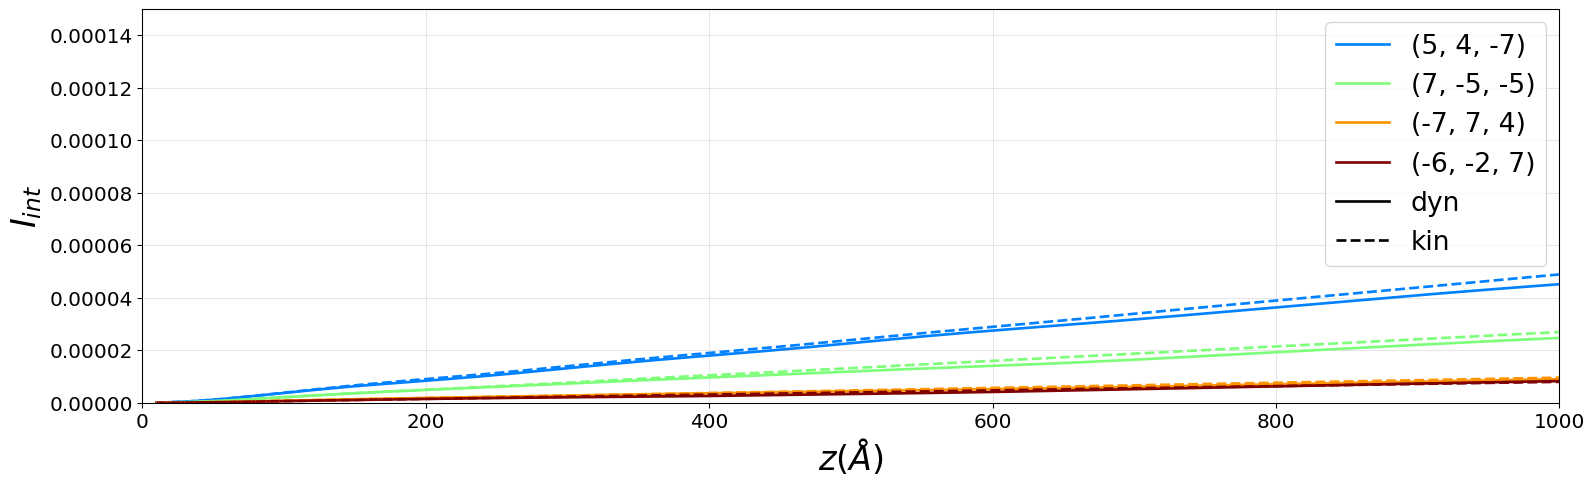

In [6]:
name='test'
rock=ut.load_pkl('dat/LTA/rocks/%s/rock_.pkl' %name)
hklf = rock.beams.loc[rock.beams.Imax>1e-3].sort_values('Imax',ascending=False).index[:20]
plot_integrated(rock,hklf[:4],lw=2,cm='jet',kin=True,opt='',figsize=figs,
               xylims=[0,1000,0,0.00015]);

In [13]:
###gathering intensities for all frames for a selection of beams at a given thickness 
hklf = rock.beams.index.tolist()#get_full_refl(Swm=0.045)

t=500
iZs,nzs=rock._get_iZs(iZs=None,zs=[t]);iZ=iZs[0]
hklf = [h for h in hklf if not type(rock.Iz_dyn[h][iZ])==np.ndarray]

df = pd.DataFrame(index=hklf,columns=['Idyns'])
df['Idyns'] = np.array([rock.Iz_dyn[h][iZ] for h in hklf])
df['Ikins'] = np.array([rock.Iz_kin[h][iZ] for h in hklf])
df['rel'] = np.abs(df.Idyns-df.Ikins)/df.Ikins*100

Saving figure :
figs/Idyn_vs_Ikin_500.png


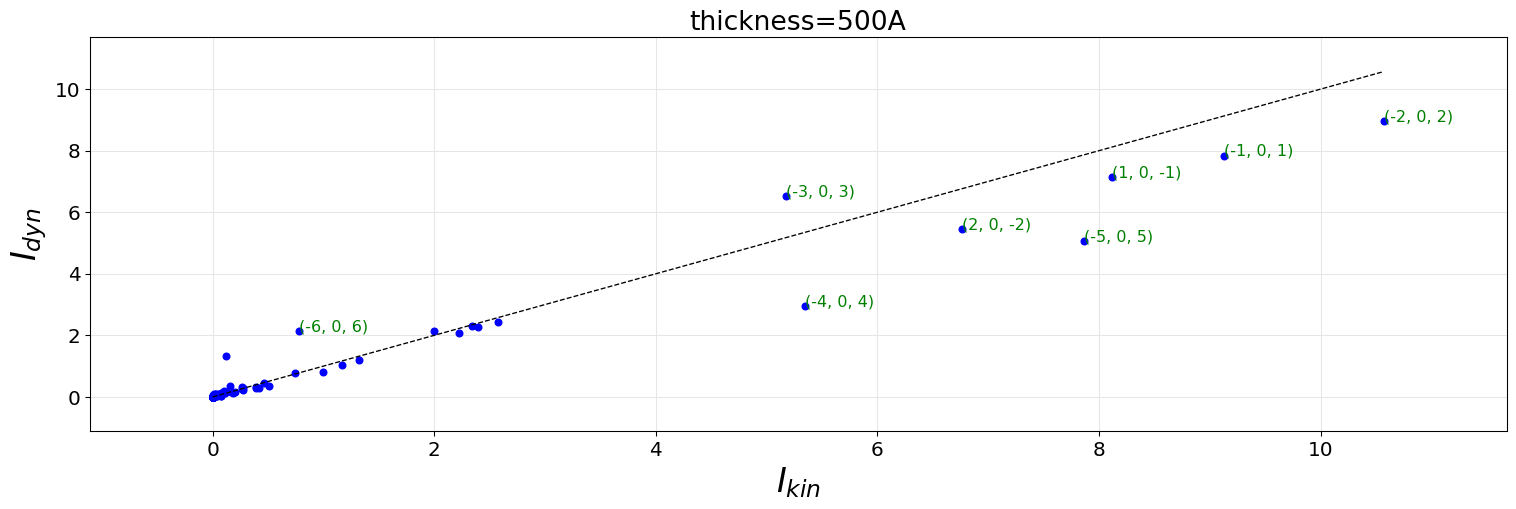

In [15]:
scale = 1e5
Imax  = df.Ikins.max()*scale
plts  = [[df.Ikins*scale,df.Idyns*scale,'bo','']]
plts  += [[[0,Imax],[0,Imax],'k--','']]
fig,ax = dsp.stddisp(plts,title="thickness=%dA" %t,labs=['$I_{kin}$','$I_{dyn}$'],figsize=figs,opt='',name="figs/Idyn_vs_Ikin_500.png",
            );

## show some reflections 
df_hkls = df.loc[(df.rel>10) & (df.Idyns*scale>2)]
for h,r in df_hkls.iterrows(): 
    x,y = r.Ikins*scale,r.Idyns*scale
    ax.annotate(h, xy=(x,y), color='g',xytext=(x,y),#ha=ha,
                fontsize=12,
                )
dsp.saveFig("figs/Idyn_vs_Ikin_500.png",ax=ax)

At 500A the overall behaviour seems to agree pretty well with kinematic values expect for reflections in a systematic row $\pm h,0,\pm l$ where dynamical effects are apparent.

### Thickness dependent R factor 

In [17]:
rock=ut.load_pkl('dat/LTA/rocks/test/rock_.pkl')
hklf=rock.get_full_refl(Swm=0.0045)
# hklf = rock.beams.index.tolist()
thicks=rock.load(0).z
Rfactors=np.zeros(thicks.shape)
for i,t in enumerate(thicks):    
    iZs,nzs=rock._get_iZs(iZs=None,zs=[t])
    Idyns = np.array([rock.Iz_dyn[h][iZs[0]] for h in hklf])
    Ikins = np.array([rock.Iz_kin[h][iZs[0]] for h in hklf])
    Rfactors[i]=np.abs(Idyns-Ikins).sum()/Ikins.sum()*100  

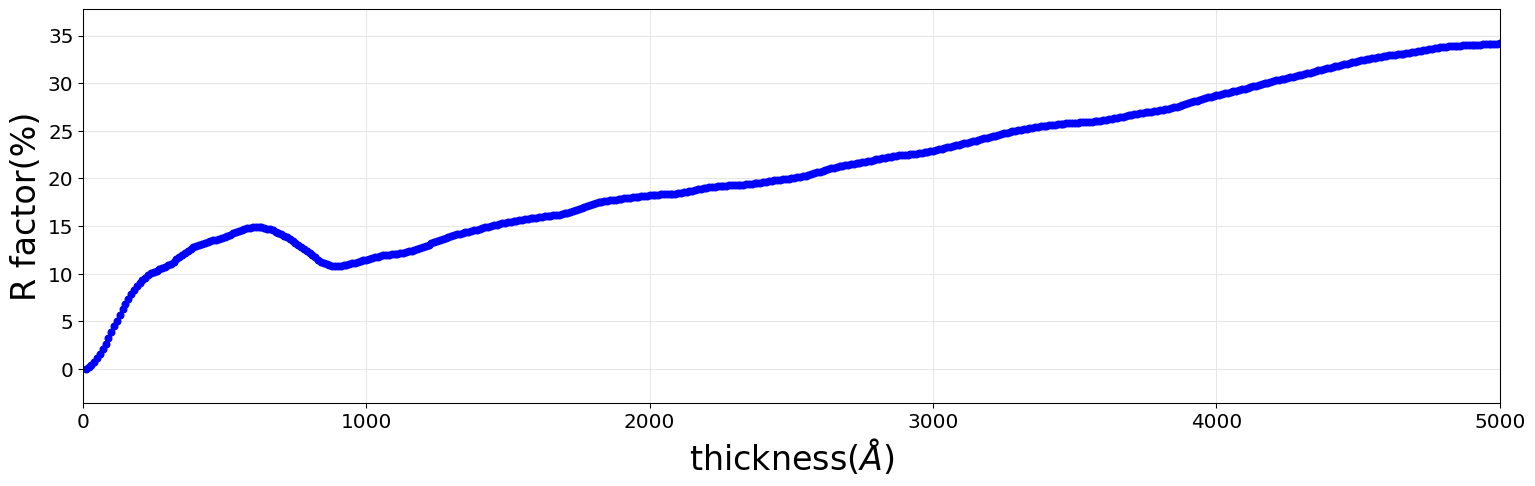

In [19]:
plts=[[thicks,Rfactors,'b-o','']]
fig,ax = dsp.stddisp(plts,labs=['thickness($\AA$)','R factor(%)'],figsize=figs,opt='',
         xylims=['x',0,5000],name="figs/Rfactor.png",
        );

Although some dynamical effects are apparent on some specific reflections, the overall kinematic approximation seem to hold pretty well up to 100nm. For larger thicknesses dynamical diffraction becomes more important. Note that this simulations so far do not include inelastic scattering which has a very strong effect on the apparent thickness of the sample.

## References 

- <a id="Kirkland2019"></a>   Kirkland, E. J. (2019). Advanced Computing in Electron Microscopy (Third Edit). p288-309. Springer
- <a id="CowleyMoodie1957"></a>  Cowley, J. M., & Moodie, A. F. (1957). The scattering of electrons by atoms and crystals. I. A new theoretical approach. Acta Crystallographica, 10(10), 609–619. https://doi.org/10.1107/s0365110x57002194
- <a id="SubramanianSpence2015"></a> Subramanian, G., Basu, S., Liu, H., Zuo, J., & Spence, J. C. H. (2015). Solving protein nanocrystals by cryo-EM diffraction : Multiple scattering artifacts. Ultramicroscopy, 148, 87–93. https://doi.org/10.1016/j.ultramic.2014.08.013
- <a id="Zuo1992"></a> Zuo, J., & Spence, J. C. H. (1992) Electron Microdiffraction.